# LLM Science exam

Most of the notebooks in this competition are based on implemenatation via Pytorch and Deberta.
This notebook suggests slightly different approach via Tensorflow and Distilbert.

## Importing dependencies

In [1]:
#Import  dependencies

import tensorflow as tf
from typing import Optional, Union
import pandas as pd
import numpy as np
from datasets import Dataset
from dataclasses import dataclass
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from transformers import TFBertForMultipleChoice, EarlyStoppingCallback, BertTokenizer, DistilBertTokenizer, TFDistilBertForMultipleChoice
from transformers.optimization import Adafactor
from sklearn.preprocessing import *
from sklearn.model_selection import *
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import callbacks
pd.set_option('display.max_colwidth', 1000)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# EDA

Apart from the training dataset from the competition that consists of only 200 rows, we will use the additional datasets with further examples, generated by 
RADEK OSMULSKI (https://www.kaggle.com/datasets/radek1/additional-train-data-for-llm-science-exam)

In [2]:
df_train = pd.concat([
    pd.read_csv('/kaggle/input/kaggle-llm-science-exam/train.csv'),
    pd.read_csv('/kaggle/input/additional-train-data-for-llm-science-exam/6000_train_examples.csv'),
    pd.read_csv('/kaggle/input/additional-train-data-for-llm-science-exam/extra_train_set.csv'),
    pd.read_csv('/kaggle/input/15k-high-quality-examples/15k_gpt3.5-turbo.csv')
])
df_train.drop('id', inplace = True, axis = 1)
df_test = pd.read_csv('/kaggle/input/kaggle-llm-science-exam/test.csv')

df_train, df_val = train_test_split(
    df_train, test_size=0.1, random_state=42, stratify = df_train['answer'] )

print(df_train.shape, df_val.shape, df_test.shape)

(19530, 7) (2170, 7) (200, 7)


In [3]:
df_test['answer'] = 'A'

In [4]:
df_train.head(2)

,prompt,A,B,C,D,E,answer
5606,What is the significance of the occurrence portrayed in the film Marathon Man (1976) on 47th Street in Manhattan?,The event depicted on 47th Street in the film Marathon Man (1976) was a significant milestone in the career of Laurence Olivier.,The occurrence portrayed on 47th Street in the film Marathon Man (1976) contributed to the recognition of Dustin Hoffman as a leading actor in Hollywood.,The occurrence on 47th Street in the film Marathon Man (1976) revealed the ongoing issues of urban decay in the 26th-century New York portrayed in the arcade game Cadillacs and Dinosaurs (1992).,The event highlighted the historical significance of 47th Street as an iconic filming location in New York City.,"The event shown on 47th Street in the film Marathon Man (1976) inspired the creation of the PBS documentary ""West 47th Street,"" co-produced by Bill Lichtenstein and June Peoples.",D
2615,What did Mihai Ralea defend against the criticism from the new-wave modernists at Sburătorul?,19th-century classical liberalism against criticism.,"Poporanism as a nationalist, culturally isolationist, and socializing phenomenon.","Ibrăileanu's ""national specificity"" against criticism.",Eugen Lovinescu's rejection of Poporanism.,The politically progressive ideas of the new-wave modernists.,C


In [5]:
for col in df_train.columns[:-1]:
    print(f'the longest string in {col} column: {df_train[col].str.len().max()}')
    print(f'the average length of the string in {col} column: {df_train[col].str.len().mean()}') 
    # some strings are longer than 512. We will not truncate the strings during preprocessing

the longest string in prompt column: 383
the average length of the string in prompt column: 83.84342037890426
the longest string in A column: 662
the average length of the string in A column: 73.17598566308244
the longest string in B column: 662
the average length of the string in B column: 73.10957501280082
the longest string in C column: 596
the average length of the string in C column: 73.13533026113672
the longest string in D column: 587
the average length of the string in D column: 73.14086021505376
the longest string in E column: 666
the average length of the string in E column: 73.06185355862775


<Axes: xlabel='answer', ylabel='count'>

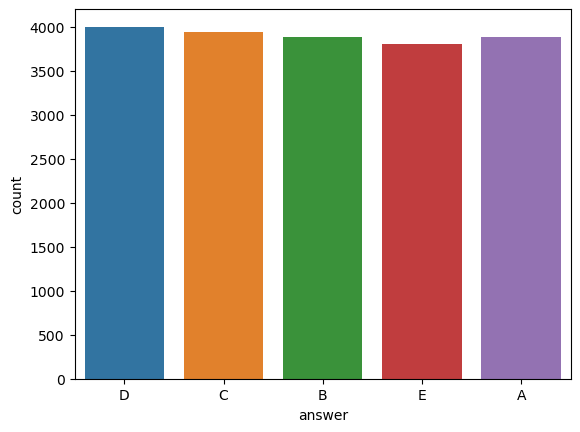

In [6]:
sns.countplot(df_train, x = 'answer') # validating that the classes are uniformly distributed

# Preprocessing

In [7]:
df_train = Dataset.from_pandas(df_train)
df_val = Dataset.from_pandas(df_val)
df_test = Dataset.from_pandas(df_test)

In [8]:
# Adapted from Huggingface Multiple Choice https://huggingface.co/docs/transformers/tasks/multiple_choice
options = 'ABCDE'
indices = list(range(5))

option_to_index = {option: index for option, index in zip(options, indices)}
index_to_option = {index: option for option, index in zip(options, indices)}

def preprocess(example):
    # The AutoModelForMultipleChoice class expects a set of question/answer pairs
    # so we'll copy our question 5 times before tokenizing
    first_sentence = [example['prompt']] * 5
    second_sentence = []
    for option in options:
        second_sentence.append(example[option])
    # Our tokenizer will turn our text into token IDs BERT can understand
    tokenized_example = tokenizer(first_sentence, second_sentence, truncation=True) # tokenizer call using 'text_pair' which basically just adds a separator between the two sentences
    tokenized_example['label'] = option_to_index[example['answer']]
    return tokenized_example

In [9]:
tokenizer = DistilBertTokenizer.from_pretrained("/kaggle/input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased")
model = TFDistilBertForMultipleChoice.from_pretrained("/kaggle/input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased")

Some layers from the model checkpoint at /kaggle/input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased were not used when initializing TFDistilBertForMultipleChoice: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForMultipleChoice were not initialized from the model checkpoint at /kaggle/input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_1

In [10]:
tokenized_train_ds = df_train.map(preprocess, batched=False, remove_columns=['prompt', 'A', 'B', 'C', 'D', 'E', 'answer'])
tokenized_val_ds = df_val.map(preprocess, batched=False, remove_columns=['prompt', 'A', 'B', 'C', 'D', 'E', 'answer'])
tokenized_test_ds = df_test.map(preprocess, batched=False, remove_columns=['prompt', 'A', 'B', 'C', 'D', 'E', 'answer'])

  0%|          | 0/19530 [00:00<?, ?ex/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/2170 [00:00<?, ?ex/s]

  0%|          | 0/200 [00:00<?, ?ex/s]

In [11]:

@dataclass
class DataCollatorForMultipleChoice:
    """
    Data collator that will dynamically pad the inputs for multiple choice received.
    """

    tokenizer:  tokenizer #PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None

    def __call__(self, features):
        label_name = "label" if "label" in features[0].keys() else "labels"
        labels = [feature.pop(label_name) for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]["input_ids"])
        flattened_features = [
            [{k: v[i] for k, v in feature.items()} for i in range(num_choices)] for feature in features
        ]
        flattened_features = sum(flattened_features, [])

        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="tf",
        )

        batch = {k: tf.reshape(v, (batch_size, num_choices, -1)) for k, v in batch.items()}
        batch["labels"] = tf.convert_to_tensor(labels, dtype=tf.int16)
        return batch
data_collator = DataCollatorForMultipleChoice(tokenizer=tokenizer)

# **Training**

In [12]:
batch_size = 16
#steps_per_epoch = 200
num_train_epochs = 10
#warmup_steps = steps_per_epoch // 10
learning_rate = 5e-5
#total_steps = steps_per_epoch * num_train_epochs - warmup_steps

optimizer = tf.keras.optimizers.Adafactor(
    learning_rate=learning_rate,  
    weight_decay=0.01)             
    
model.compile(
    optimizer=optimizer,
    #loss='categorical_crossentropy',  # Specify your desired loss function
    metrics=[
        'accuracy',
    ])

In [13]:
EarlyStopping = tf.keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    patience=20,
                    restore_best_weights=True,
                    start_from_epoch=5,
                )
reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                              factor=0.9, 
                                              patience=2,
                                              verbose=1, 
                                              min_lr=1e-7)
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_weights_only=True,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [14]:
tf_train_set = model.prepare_tf_dataset(
    tokenized_train_ds,
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    tokenized_val_ds,
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
    tokenized_test_ds,
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)


In [15]:
history = model.fit(
    tf_train_set,
    validation_data=tf_validation_set,
    epochs = num_train_epochs,
    #batch_size = batch_size,
    callbacks=[EarlyStopping, reduce_lr, model_checkpoint],
    #steps_per_epoch = steps_per_epoch
)

Epoch 1/10
1221/1221 [==============================] - 805s 625ms/step - loss: 1.5858 - accuracy: 0.2725 - val_loss: 1.5206 - val_accuracy: 0.3963 - lr: 5.0000e-05
Epoch 2/10
1221/1221 [==============================] - 690s 565ms/step - loss: 1.4944 - accuracy: 0.3566 - val_loss: 1.4535 - val_accuracy: 0.4230 - lr: 5.0000e-05
Epoch 3/10
1221/1221 [==============================] - 689s 564ms/step - loss: 1.4328 - accuracy: 0.3929 - val_loss: 1.4161 - val_accuracy: 0.4359 - lr: 5.0000e-05
Epoch 4/10
1221/1221 [==============================] - 673s 551ms/step - loss: 1.3826 - accuracy: 0.4264 - val_loss: 1.3921 - val_accuracy: 0.4465 - lr: 5.0000e-05
Epoch 5/10
1221/1221 [==============================] - 689s 564ms/step - loss: 1.3421 - accuracy: 0.4434 - val_loss: 1.3784 - val_accuracy: 0.4433 - lr: 5.0000e-05
Epoch 6/10
1221/1221 [==============================] - 689s 564ms/step - loss: 1.2958 - accuracy: 0.4718 - val_loss: 1.3735 - val_accuracy: 0.4419 - lr: 5.0000e-05
Epoch 7/10

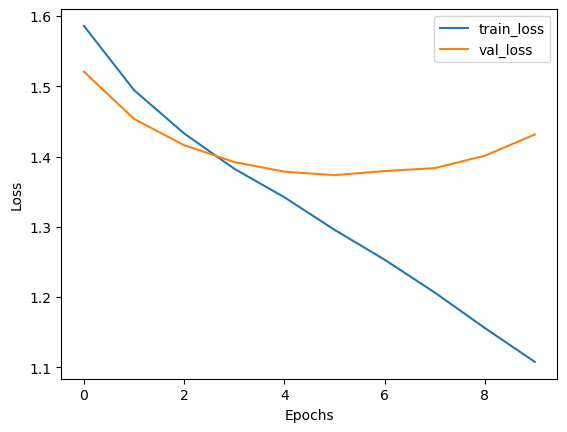

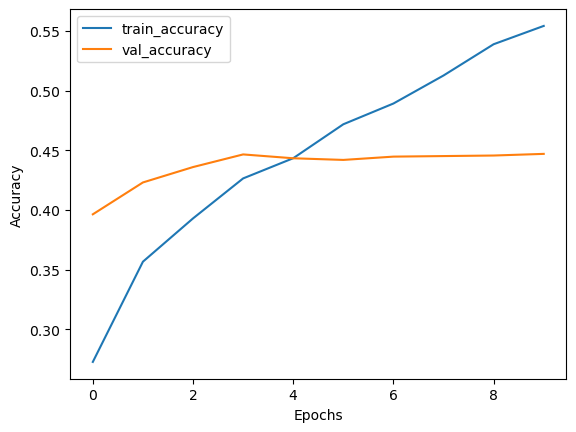

In [16]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
model.summary()

Model: "tf_distil_bert_for_multiple_choice"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 66,954,241
Trainable params: 66,954,241
Non-trainable params: 0
_________________________________________________________________


# Predicting on the test set 

In [18]:
df_test = pd.DataFrame(df_test) # back to Pandas
test_predictions = model.predict(tf_test_set).logits
predictions_as_ids = np.argsort(-test_predictions, 1)
predictions_as_answer_letters = np.array(list('ABCDE'))[predictions_as_ids]
predictions_as_string = df_test['prediction'] = [
    ' '.join(row) for row in predictions_as_answer_letters[:, :3]
]
print(predictions_as_string[:3])

13/13 [==============================] - 5s 246ms/step
['D B C', 'D C E', 'A C B']


In [19]:
submission = df_test[['id', 'prediction']]
submission.to_csv('submission.csv', index=False)

pd.read_csv('submission.csv').head(2)

,id,prediction
0,0,D B C
1,1,D C E


## More to do

- Implement cross-validation
- Using another loss-function
- Using another pre-trained model for transfer learning